# Training a CNN on the Fruit360 dataset

## Dependencies, dataset import

In [44]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Assuming you are working on google colab, create a Kaggle account and run the following cell to import the dataset.

If you are working locally, you may skip this step and retrieve the dataset through other means.

In [6]:
from google.colab import files

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Skipping, found downloaded files in "./fruits" (use force=True to force download)


## Data Preprocessing



In [7]:
data_dir = 'fruits/fruits-360_dataset/fruits-360/'

train_dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

test_dataset = ImageFolder(data_dir + "Test", transform=ToTensor())

In [8]:
dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: fruits/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: fruits/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: ToTensor()


In [9]:
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classe {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classe 131
Classes Names: ['Pear Kaiser', 'Apricot', 'Plum 3', 'Tomato Cherry Red', 'Grape White 3', 'Nut Pecan', 'Peach Flat', 'Cantaloupe 1', 'Limes', 'Tomato 1', 'Apple Braeburn', 'Mango Red', 'Clementine', 'Grape Blue', 'Pepper Red', 'Tamarillo', 'Pepper Green', 'Apple Pink Lady', 'Salak', 'Tomato 2', 'Plum', 'Tomato not Ripened', 'Passion Fruit', 'Pomelo Sweetie', 'Rambutan', 'Kohlrabi', 'Nectarine', 'Peach 2', 'Pepino', 'Grape White', 'Huckleberry', 'Pear Abate', 'Carambula', 'Chestnut', 'Physalis with Husk', 'Pineapple Mini', 'Kaki', 'Tangelo', 'Pineapple', 'Ginger Root', 'Melon Piel de Sapo', 'Potato Red', 'Tomato Yellow', 'Tomato 4', 'Apple Red 1', 'Onion Red Peeled', 'Lemon', 'Cherry 1', 'Redcurrant', 'Kumquats', 'Grape White 4', 'Pear Red', 'Cauliflower', 'Guava', 'Cantaloupe 2', 'Mandarine', 'Lemon Meyer', 'Eggplant', 'Cucumber Ripe', 'Avocado ripe', 'Avocado', 'Granadilla', 'Grapefruit Pink', 'Tomato 3', 'Potato Red Washed', 'Mulberry', 'Blueberry', 'Strawb

In [10]:
img, label = train_dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

Label (numeric): 0
Label (textual): Pear Kaiser


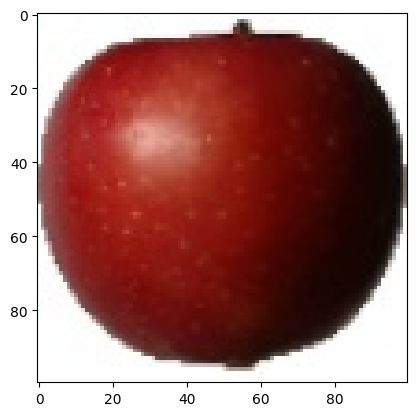

In [11]:
img, label = train_dataset[5]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Defining and applying data transforms

In [132]:
train_tfms = tt.Compose([
                         tt.RandomCrop(100, padding=4, padding_mode='reflect'),
                         tt.Resize((100,100)),
                         tt.RandomHorizontalFlip(),
                         tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),

                         ])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Resize((100,100)),
                         ])

In [13]:
dataset = ImageFolder(data_dir + "/Training", transform=train_tfms)

Testing = ImageFolder(data_dir + "/Test", transform=valid_tfms)

### Creating the training validation 80/20 split

In [134]:
torch.manual_seed(0)
val_size = round(len(dataset) * 0.2)
train_size = round(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(54154, 13538)

### Putting data into batches


In [16]:
batch_size=400

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Creating the model

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### A convolutional neural network will be used for this task.

In [22]:
class Fruit360CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, 5),

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64*5*5, 131))

    def forward(self, xb):
      return self.network(xb)

model = Fruit360CnnModel().to(device)
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=1600, out_features=131, bias=True)


## Training the model

In [23]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []


    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):

        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()


            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
model = to_device(model, device)
model

Fruit360CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Dropout(p=0.3, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=1600, out_features=131, bias=True)


In [25]:
os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.8749003410339355, 'val_acc': 0.004436473827809095}]

In [26]:
epochs = 4
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 1.2270, val_loss: 0.5842, val_acc: 0.8351
Epoch [1], train_loss: 0.1216, val_loss: 0.0294, val_acc: 0.9912
Epoch [2], train_loss: 0.0210, val_loss: 0.0062, val_acc: 0.9987
Epoch [3], train_loss: 0.0054, val_loss: 0.0007, val_acc: 0.9999
CPU times: user 12.3 s, sys: 9.65 s, total: 22 s
Wall time: 3min 44s


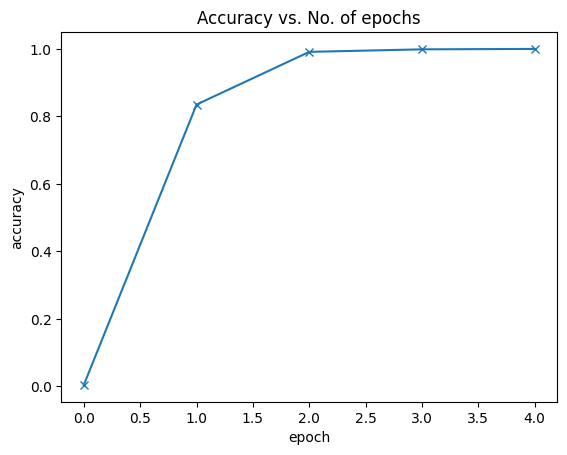

In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

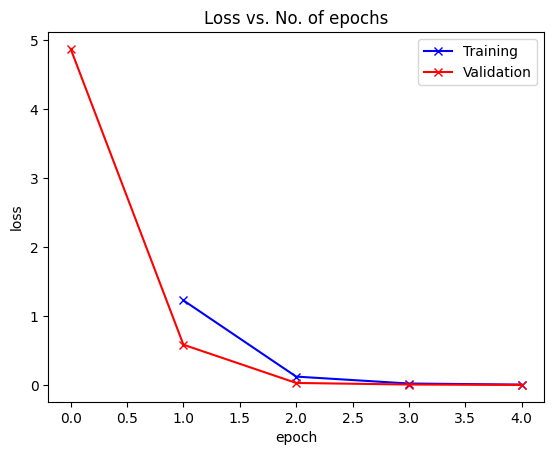

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Testing the model

Testing on the test dataset

In [30]:
test_tfms = tt.Compose([tt.Resize((100, 100)),
                        tt.ToTensor()])

In [31]:
test_dataset = ImageFolder(data_dir + "Test", transform=test_tfms)

In [32]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.06735915690660477, 'val_acc': 0.9900000095367432}

In [33]:
def predict_image(img, model):

    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)

    _, preds  = torch.max(yb, dim=1)

    return dataset.classes[preds[0].item()]

Label: Kiwi Predicted: Kiwi


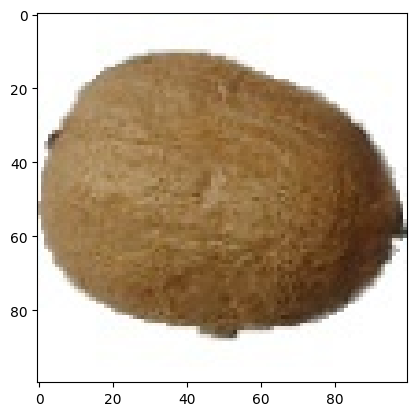

In [106]:
# Single tests

img, label = test_dataset[9600] # split the image into image and label
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], 'Predicted:', predict_image(img, model))

Testing on your own images

In [124]:
def resize_image(dir_to_image):

  original_img = Image.open(image_name)

  target_size = (100, 100)
  resized_img = original_img.resize(target_size)

  to_tensor_transform = transforms.ToTensor()
  resized_tensor = to_tensor_transform(resized_img)

  return resized_tensor


In [127]:
uploaded = files.upload()

Saving download.jpg to download.jpg


In [129]:
image_name = list(uploaded.keys())[0]
resized_image = resize_image(image_name)


In [130]:
prediction = predict_image(resized_image, model)
prediction

'Watermelon'

##Saving the model and using it externally

This saves the model to a file `model.pth` in the current directory:

In [ ]:
torch.save(model.state_dict(), 'model.pth')

To load and use the model:

In [ ]:
model = Fruit360CnnModel()

model.load_state_dict(torch.load('model.pth'))

model.eval()

Be sure to import the `ImageClassificationBase` class from the file it is defined it.